In this week's tutorial we will look into vision transformers. At the end of this tutorial you should be able to:
- Build a vision transformer
- Use it to classify images
- Understand attention

**If possible, use a GPU to train the model (if you don't have a GPU you can try to run on Google Colab).**

# Building a Vision Transformer (ViT)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device.type}.")

## Loading the data

We will work with the FashionMNIST dataset. Let's load the data.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((120, 120), antialias=True)
     ]
    )

batch_size = 2048

trainset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
    )

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

100%|██████████| 26421880/26421880 [00:01<00:00, 15196146.98it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273350.90it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4975764.57it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20389307.83it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



We can visualise one of the images in the dataset. Note that we have resized the images to be of size 120x120.

In [ ]:
def view_tensor_image(img, label=None):
    img = img.permute(1,2,0)
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if label:
      plt.title(classes[label])
    plt.show()

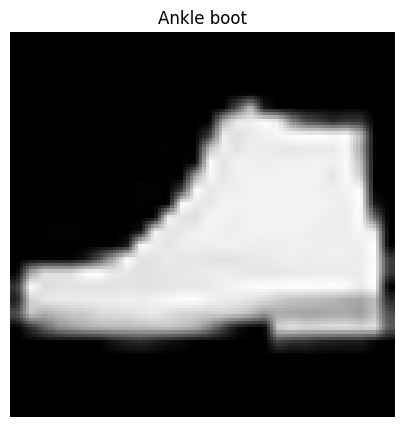

In [ ]:
view_tensor_image(img=trainset[42][0], label=trainset[42][1])

The first step will be to split the data into the required dimenions. We want to partition each image into a square grid with size of side num_patches_per_row. Each patch or square in our grid will be inputted as a component to the images in the batch.

Let's define a function that partitions an image into num_patches_per_row x num_patches_per_row different images and returns them as a batch of flattened tensors. For example, if we split one image of size 120x120 into 9 patches (3 per row), we want to obtain a tensor of size (9x1600) - 9 patches of size 40x40 flattened into 1-dimensional tensors of size 1600.

In [ ]:
class Patches(object):
  def __init__(self, num_patches_per_row):
    self.num_patches_per_row = num_patches_per_row

  def __call__(self, image):
    # Fill in steps
    # compute patch size
    patch_size =
    # compute patches (hint: use .unfold) - should get a tensor of dimension (num_patches, patch_size, patch_size)
    patches =
    # flatten patches
    patches_flat = patches.contiguous().view(self.num_patches_per_row**2, -1)
    return patches_flat

We will apply the transformation when we load the data, so that we obtain our dataset in the desired format.

In [ ]:
num_patches_per_row=3

transform_patches = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((120, 120), antialias=True),
     Patches(num_patches_per_row)
     ]
    )

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_patches)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_patches)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Let's check the dimension of an image in our dataset.

In [ ]:
print(trainset[42][0].size())

We can also visualise each of the patches separately to confirm that they make up the images in our train set.

In [ ]:
def view_image_patches(img, label=None):
  image_list = []
  # get length of side of patch
  img_size = int(np.sqrt(img.shape[1]))
  # iterate through each patch in img
  for i in range(img.shape[0]):
    # reshape image
    reshaped_img = img[i].view(1, img_size, img_size)
    # add to list
    image_list.append(reshaped_img)

  # display in grid
  num_rows = int(np.sqrt(img.shape[0]))
  img_grid = torchvision.utils.make_grid(image_list, nrow=num_rows, normalize=True, pad_value=0.9)
  img_grid = img_grid.permute(1, 2, 0)

  # plot images
  plt.figure(figsize=(5, 5))
  plt.title(f"{classes[label]} - patches")
  plt.imshow(img_grid)
  plt.axis("off")
  plt.show()

# visualise image
view_image_patches(trainset[42][0], label=trainset[42][1])

## Implementing a Vision Transformer

Let's begin the code for the Vision Transformer. We follow the ideas from https://arxiv.org/pdf/2010.11929.pdf.

### Positional embeddings

Each initial tensor containing the pixel values of the flattened patches will be encoded into a smaller dimension which we call the model dimension. We will denote this as d_model. Hence, if we denote length as the number of patches, w will end up with a tensor of size length x d_model for each train image in our batch.

It is important to make sure that the model is aware of the position of each of the patches within the image (that is, the patches are not just randomly placed together, they are placed in a certain order that is important in order for the image to make sense). To do this, we will use a positional embedding of the image. We will add the position number (e.g., if we have 9 patches, 0 to 8) to the encoded values of the corresponding patch.

For now, let's define an object that returns a tensor of the same size as length x d_model. Each entry will contain the positional embedding of the patch it would belong to if we were considering the values of the entries for each patch instead.

In [ ]:
class PositionalEncoding(nn.Module):
    """
    compute trivial positional encoding
    """
    def __init__(self, length, d_model, device):
        """
        constructor of positional encoding class
        :param length: first dimension of input (number of patches)
        :param d_model: dimension of input after mapping
        """
        super(PositionalEncoding, self).__init__()

        pos = torch.arange(0, length, device=device)
        pos = pos.float().unsqueeze(dim=1)

        self.encoding = pos.tile((1, d_model))
        self.encoding.requires_grad = False

    def forward(self, x):
        return self.encoding

### Task: explore what the above function does

Copy out the steps of computation so you understand what the function is doing exactly and what the dimension of the output is.

In [6]:
bs = 2
length = 5
d_model = 10
x = torch.randn((bs, length, d_model))

# implement steps in forward function, first step is done below
pos = torch.arange(0, length, device=device)

print(pos)

tensor([0, 1, 2, 3, 4])


### Attention

Our next step will be to define the multi-head attention layers. We first define an attention layer. Given our matrices $Q, K$ and $V$, the output will be given by
$$
\text{output} = softmax \left (\frac{QK^T}{\sqrt{d}}\right ).
$$

Instead of using all our input directly in one attention layer, we will split it and apply attention on each of the parts separately. The number of attention heads determines how many chunks of our input we use. Our input will be split along the dimension of size d_model. Thus, if n_heads is the number of heads for our multi-attention layer, we will end up with tensors of size determined by the batch size, head number, length (number of patches) and d_model/n_heads. This is done for our $Q, K$ and $V$ tensors.

Note that $d$ in the above fomula will be given by d_model/n_heads.

In [ ]:
class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaleDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v):
        # input is of size (batch_size, n_heads, length, d_model/n_heads)
        batch_size, head, length, d_tensor = k.size()
        # fill in steps
        # calculate Key^T
        k_t =
        # do dot-product between Query and Key^T
        # score should be [batch_size, n_heads, length, length]
        score =
        # softmax
        score =
        # output is [batch_size, n_heads, length, d_model/n_heads]
        output =
        return output, score

Next, we can define a class that applies the necessary transformations to our input to get it to the right dimensions, and then applies the attention layer.

1.   Scale our input with the weight matrices $W^Q, W^K$ and $W^V$ to get $Q, K$ and $V$
2.   Split $Q, K$ and $V$ into smaller parts
3.   Pass through attention layer
4.   Concatenate outputs from all attention heads into one final output



In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, n_head, device):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        # to get the q,v,k we do a linear multiplication
        self.w_q = nn.Linear(d_model, d_model, device=device)
        self.w_k = nn.Linear(d_model, d_model, device=device)
        self.w_v = nn.Linear(d_model, d_model, device=device)
        self.w_concat = nn.Linear(d_model, d_model, device=device)

    def forward(self, q, k, v): # in our case q, k and v will be our input (three times)
        # fill in steps
        # take in Q,K,V and do dot product with big weight matrices
        q, k, v =

        # split tensor by number of heads
        # (i.e. split big vector into smaller chunks = equivalent to multiplying each q,v,k with many smaller weight matrices)
        q, k, v =

        # do attention on each head
        out, attention_score =

        # concatenate and pass through a linear layer; output has size [batch_size, 1, length, d_model]
        out = self.concat(out)
        out = self.w_concat(out)

        return out

    def split(self, tensor):
        batch_size, length, d_model = tensor.size()
        if d_model % self.n_head != 0:
            raise AssertionError('Model dimension d_model must be divisible by number of attention heads n_head.')
        d_tensor = d_model // self.n_head
        # this splits a big vector of size (batch_size, length, d_model) into (batch_size,length, n_head, d_model/n_head)
        tensor = tensor.view(batch_size, length, self.n_head, d_tensor)
        # transpose to (batch_size, n_head, length, d_model/n_head)
        tensor = tensor.transpose(1, 2)
        return tensor

    @staticmethod
    def concat(tensor):
        # d_tensor is d_model / n_head
        batch_size, head, length, d_tensor = tensor.size()
        d_model = head * d_tensor
        # contiguous is used to avoid error from view() as transpose makes tensor non-contiguous
        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)
        return tensor

### Structure of layers

The structure of the (group of) layers will be as follows:

1.   Layer normalisation
2.   Multihead attention layer + skip connection
3.   Layer normalisation
4.   Linear layer
6.   ReLU
5.   Linear layer + skip connection

Let's first start with implementing LayerNorm. We want to normalise along the patches of each image in the batch.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, device, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model, device=device))
        self.beta = nn.Parameter(torch.zeros(d_model, device=device))
        self.eps = eps

    def forward(self, x):
        # mean is taken over last dimension; this is def of layernorm; so over d_model
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        # so output remains of size x
        out = (x-mean) / torch.sqrt(var + self.eps)
        return out

We can now implement the structure of the layer defined above.

In [ ]:
class OneLayer(nn.Module):

    def __init__(self, d_model, n_hidden, n_head, device):
        super(OneLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head, device=device)
        self.norm1 = LayerNorm(d_model=d_model, device=device)
        # this next piece is the positionwise feedforward - to maintain sizes
        self.linear2 = nn.Linear(d_model, n_hidden, device=device)
        self.relu = nn.ReLU()
        self.linear3 = nn.Linear(n_hidden, d_model, device=device)
        self.norm2 = LayerNorm(d_model=d_model, device=device)

    def forward(self, x):
        x_ = self.norm1(x)
        x = self.attention(q = x_, k = x_, v = x_) + x
        x_ = self.norm2(x)
        x = self.linear3(self.relu(self.linear2(x_))) + x
        return x

### Structure of Vision Transformer

We can now combine all the code above to obtain the structure of the Vision Transformer in order to perform classification.

1.   Map flattened patches of size d_init into d_model
2.   Add positional encoding
3.   Apply layers (OneLayer defined above) for n_layers number of times
4.   Average pool to reshape output
5.   Linear layer to map to a tensor with size correposnding to the number of classes (10 in our case)
6.   Softmax to get probabilities



In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, length, d_init, d_model, n_hidden, n_head, n_layers, n_classes, device):
        super().__init__()
        self.linear1 = nn.Linear(d_init, d_model, device=device)  # maps initial dimension to d_model
        self.encoding = PositionalEncoding(length=length, d_model=d_model, device=device)

        #list of layers
        layer_list = []
        for _ in range(n_layers):
            layer_list.append(OneLayer(d_model=d_model, n_hidden=n_hidden, n_head=n_head, device=device))
        self.layers = nn.ModuleList(layer_list)

        self.avgpool = nn.AdaptiveAvgPool2d((1, d_model))
        self.linear2 = nn.Linear(d_model, n_classes, device=device)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Map the input dimension to model dimension
        x = self.linear1(x)
        # Add positional encoding
        x = self.encoding(x) + x
        # Attention layers
        for layer in self.layers:
            x = layer(x)
        # Global 1D pooling layer (x is of size [n_batches, length, d_model])
        x = self.avgpool(x).squeeze()
        # Final linear layer and softmax to map to the correct dimension
        x = self.linear2(x)
        x = self.softmax(x)
        # All done :)
        return x

    def __repr__(self):
        return "vision_transformer"

Let's write a function to evaluate accuracy.

In [ ]:
def accuracy(dataloader, model, n=1):
  num_samples = 0
  num_correct = 0

  for i, data in enumerate(dataloader):
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
      output = model(images)
    _, inds = torch.topk(output, n)
    num_correct += int(torch.sum(labels == inds.flatten()))
    num_samples += len(labels)

  return num_correct / num_samples

We now have to define the hyperparameters of our network. The number of patches and length of the flattened patches can be extracted from the structure of our dataset. Batch size was also specified when we loaded the dataset.

The other hyperparameters we have to choose ourselves. Feel free to modify these to try to obtain a better performance of the model.

In [ ]:
num_patches, d_init = trainset[0][0].shape

params = {
    'length': num_patches,  # Number of patches the image is broken up into
    'd_init': d_init,  # Size of the flattened image patch
    'd_model': 100,
    'n_hidden': 100,
    'n_head': 5,
    'n_layers': 5,
    'n_classes': 10,
    'device': device
}

model = VisionTransformer(**params)

Let's train the model. If it is taking too long to train just make sure that the model works (that is, that it runs one epoch).

In [ ]:
num_epochs = 60

cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
losses = []
accuracies = []
pbar = tqdm(range(num_epochs))

for epoch in pbar:
  avg_loss = []  # average loss across batches
  for i, data in enumerate(trainloader):
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    loss = cross_entropy_loss(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss.append(loss.detach().item())

  loss_averaged = np.array(avg_loss).mean()
  scheduler.step()

  # Evaluate the model every 25 time steps on the test set
  if epoch % 25 == 0:
    accuracies.append(accuracy(testloader, model, n=1))

  # Update progress bar
  description = (
    f'Loss {loss_averaged:.3f} | '
    f'learning rate {optimizer.param_groups[0]["lr"]:.6f}'
  )
  pbar.set_description(description)
  losses.append(np.array(avg_loss).mean())


Let's evaluate the model.

In [ ]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Cross entropy loss')
plt.show()

In [ ]:
plt.bar(25*np.arange(len(accuracies)), accuracies)
plt.xlabel('Epochs')
plt.ylabel('Test set top-1 accuracy')
plt.xticks(25*np.arange(len(accuracies)))
plt.show()

In [ ]:
acc = accuracy(testloader, model, n=1)
print(f"Model achieved {100*acc:.2f}% accuracy on test set.")

References:

- [An image is worth 16X16 words: Transformers for image recognition at scale](https://arxiv.org/pdf/2010.11929.pdf)
- [Better plain ViT baselines for ImageNet-1k](https://arxiv.org/pdf/2205.01580.pdf)